In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [50]:
raw_dir = "../../data/_raw/edgar"

## EDGAR Raw files processing, co2 eq converting & concat

In [51]:
#Process CH4 & converting eqCO2 (coef 25)

df_ch4 = pd.read_csv(f'{raw_dir}/edgar_file_em_ch4_sect.csv')

df_ch4.columns = df_ch4.columns.astype(str).str.replace('Y_', '')


# Melt DataFrame to convert year columns into a single column
filtered_columns = [col for col in df_ch4.columns if not bool(re.match(r'^\d{4}$', col))]
df_ch4 = df_ch4.melt(id_vars=filtered_columns,
                                            var_name='year', value_name='value_kt')
# Extract the year from the column name
df_ch4['year'] = df_ch4['year'].astype(int)

#creating value_eqco2 (x25) (ratio de 2010 sur somme des value VS ce qui apparait en eq C02 sur le datashiftportal)
df_ch4['value_mteqco2']=df_ch4['value_kt']*(25/1000)
                            

In [52]:
#process N2O & converting eqCO2 (coef 300)

df_n2o = pd.read_csv(f'{raw_dir}/edgar_file_em_n2o_sect.csv')

df_n2o.columns = df_n2o.columns.astype(str).str.replace('Y_', '')


# Melt DataFrame to convert year columns into a single column
filtered_columns = [col for col in df_n2o.columns if not bool(re.match(r'^\d{4}$', col))]
df_n2o = df_n2o.melt(id_vars=filtered_columns,
                                            var_name='year', value_name='value_kt')
# Extract the year from the column name
df_n2o['year'] = df_n2o['year'].astype(int)

#Conversion value_eqco2 (x300) (ratio de 2010 sur somme des value VS ce qui apparait en eq C02 sur le datashiftportal)
df_n2o['value_mteqco2']=df_n2o['value_kt']*(300/1000)

In [53]:
#processing f gases & converting eqco2 (x1740)

df_fgases = pd.read_csv(f'{raw_dir}/edgar_file_em_fgas_sect.csv')

df_fgases.columns = df_fgases.columns.astype(str).str.replace('Y_', '')

# Melt DataFrame to convert year columns into a single column
filtered_columns = [col for col in df_fgases.columns if not bool(re.match(r'^\d{4}$', col))]
df_fgases = df_fgases.melt(id_vars=filtered_columns,
                                            var_name='year', value_name='value_kt')
# Extract the year from the column name
df_fgases['year'] = df_fgases['year'].astype(int)

#Conversion value_eqco2 (x1740) (ratio de 2005 sur somme des value VS ce qui apparait en eq C02 sur le datashiftportal)
df_fgases['value_mteqco2']=df_fgases['value_kt']*(1740/1000)

#replacing substances with  F Gases
df_fgases['Substance']='F-Gas'

In [54]:
#processing CO2 

df_co2 = pd.read_csv(f'{raw_dir}/edgar_file_em_co2_sect.csv')

df_co2.columns = df_co2.columns.astype(str).str.replace('Y_', '')

# Melt DataFrame to convert year columns into a single column
filtered_columns = [col for col in df_co2.columns if not bool(re.match(r'^\d{4}$', col))]
df_co2 = df_co2.melt(id_vars=filtered_columns,
                                            var_name='year', value_name='value_kt')
# Extract the year from the column name
df_co2['year'] = df_co2['year'].astype(int)

#Conversion value_eqco2 (x1740) (ratio de 2005 sur somme des value VS ce qui apparait en eq C02 sur le datashiftportal)
df_co2['value_mteqco2']=df_co2['value_kt']/1000

In [55]:
#files concat 
df_merged =pd.concat([df_co2, df_ch4, df_fgases, df_n2o], ignore_index=True)


## Mapping sectors & regions

In [56]:
# regions

df_reg = pd.read_csv('../../data/_info/__INFO_UN_M49_fr.csv')
#left joining
df_merged_reg = df_merged.merge(df_reg, left_on='Country_code_A3', right_on='ISO-alpha3 Code', how='left')

In [57]:
# IPCC Category mapping : sector

def map_sector(ipcc_code):
    if ipcc_code.startswith('1'):
        return 'Energy'
    elif ipcc_code.startswith('2'):
        return 'Industrial Processes and Product Use'
    elif ipcc_code.startswith('3'):
        return 'Agriculture'
    elif ipcc_code.startswith('4'):
        return 'Waste'
    else:
        return 'Other'

df_merged_reg_sect = df_merged_reg.copy()
df_merged_reg_sect['sector'] = df_merged_reg_sect['ipcc_code_2006_for_standard_report'].apply(map_sector)  


## Cleaning & saving processed file

In [59]:
#Renaming columns
df_merged_reg_sect.rename(columns={
    'Country_code_A3': 'country_code_a3',
    'Name': 'country_name',
    'Substance': 'gas',
    'Region Name': 'region_name'
}, inplace=True)

#Selecting columns
selected_columns = ['country_code_a3', 'country_name', 'region_name', 'sector', 'gas', 'year', 'value_kt', 'value_mteqco2']
df_processed_edgar = df_merged_reg_sect[selected_columns].copy()

#Adding source 
df_processed_edgar['source']='EDGAR'


display(df_processed_edgar)

#Saving file 

df_processed_edgar.to_csv('../../data/_processed/edgar_processed_ch4_n2o_co2_fgases.csv', index=False)

,country_code_a3,country_name,region_name,sector,gas,year,value_kt,value_mteqco2,source
0,ABW,Aruba,Amériques,Energy,CO2,1970,0.022397,0.000022,EDGAR
1,ABW,Aruba,Amériques,Energy,CO2,1970,12.228673,0.012229,EDGAR
2,ABW,Aruba,Amériques,Energy,CO2,1970,0.879948,0.000880,EDGAR
3,ABW,Aruba,Amériques,Energy,CO2,1970,0.058367,0.000058,EDGAR
4,ABW,Aruba,Amériques,Energy,CO2,1970,NaN,NaN,EDGAR
...,...,...,...,...,...,...,...,...,...
800815,ZWE,Zimbabwe,Afrique,Agriculture,N2O,2021,12.977390,3.893217,EDGAR
800816,ZWE,Zimbabwe,Afrique,Agriculture,N2O,2021,0.823008,0.246902,EDGAR
800817,ZWE,Zimbabwe,Afrique,Agriculture,N2O,2021,0.001959,0.000588,EDGAR
800818,ZWE,Zimbabwe,Afrique,Waste,N2O,2021,0.565762,0.169729,EDGAR


## Représentation graphiques

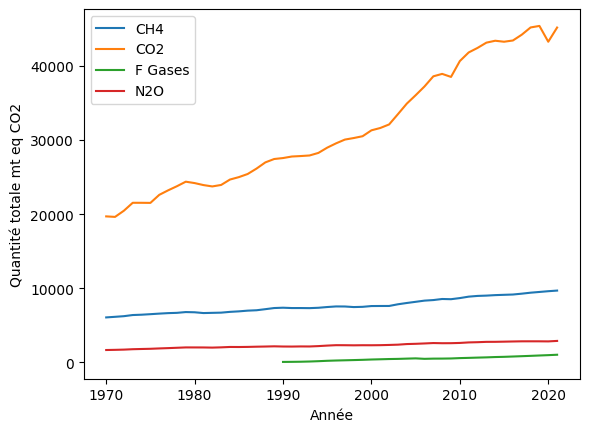

In [60]:
# Quantité par gaz

# Grouper par année et substance et calculer la somme de value_eqco2
df_grouped = df_processed_edgar.groupby(['year', 'gas'])['value_mteqco2'].sum().reset_index()

# Pivoter les données pour avoir les substances comme colonnes
df_pivot = df_grouped.pivot(index='year', columns='gas', values='value_mteqco2')

# Tracer le graphique
df_pivot.plot(kind='line')

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Année')
plt.ylabel('Quantité totale mt eq CO2')


# Afficher le graphique
plt.legend()
plt.show()


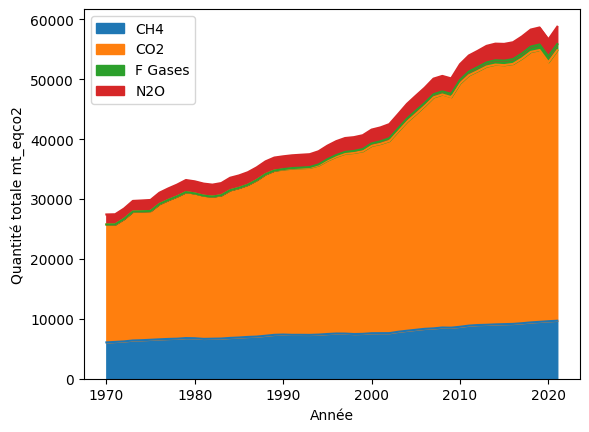

In [69]:
#Graphiques empilés

# Grouper par année et substance et calculer la somme de value_eqco2
df_grouped = df_processed_edgar.groupby(['year', 'gas'])['value_mteqco2'].sum().reset_index()

# Pivoter les données pour avoir les substances comme colonnes
df_pivot = df_grouped.pivot(index='year', columns='gas', values='value_mteqco2')

# Tracer le graphique en courbes empilées
df_pivot.plot(kind='area', stacked=True)

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Année')
plt.ylabel('Quantité totale mt_eqco2')


# Afficher le graphique
plt.legend()
plt.show()


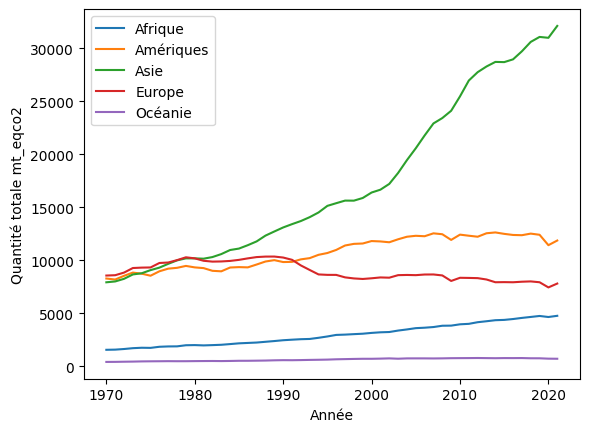

In [68]:
# Quantité par region

# Grouper par année et substance et calculer la somme de value_eqco2
df_grouped = df_processed_edgar.groupby(['year', 'region_name'])['value_mteqco2'].sum().reset_index()

# Pivoter les données pour avoir les substances comme colonnes
df_pivot = df_grouped.pivot(index='year', columns='region_name', values='value_mteqco2')

# Tracer le graphique
df_pivot.plot(kind='line')

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Année')
plt.ylabel('Quantité totale mt_eqco2')


# Afficher le graphique
plt.legend()
plt.show()

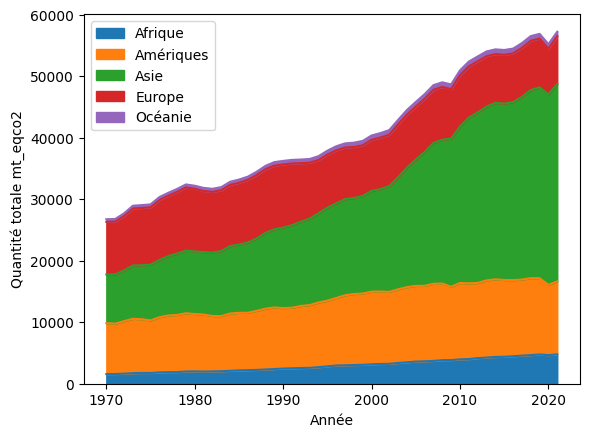

In [67]:
# Graphique empilé
# Grouper par année et substance et calculer la somme de value_eqco2
df_grouped = df_processed_edgar.groupby(['year', 'region_name'])['value_mteqco2'].sum().reset_index()

# Pivoter les données pour avoir les substances comme colonnes
df_pivot = df_grouped.pivot(index='year', columns='region_name', values='value_mteqco2')

# Tracer le graphique en courbes empilées
df_pivot.plot(kind='area', stacked=True)

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Année')
plt.ylabel('Quantité totale mt_eqco2')


# Afficher le graphique
plt.legend()
plt.show()

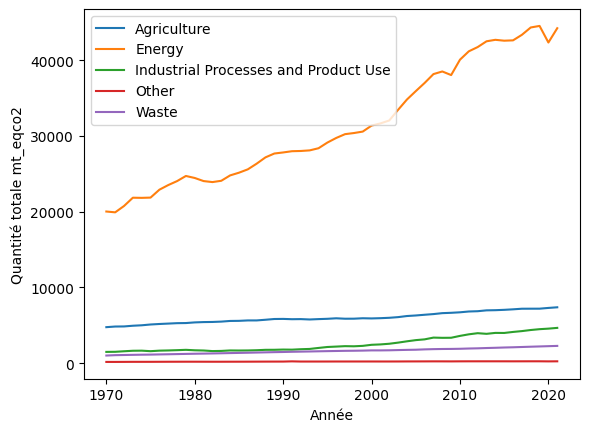

In [66]:
#quantité par secteur


# Grouper par année et substance et calculer la somme de value_eqco2
df_grouped = df_processed_edgar.groupby(['year', 'sector'])['value_mteqco2'].sum().reset_index()

# Pivoter les données pour avoir les substances comme colonnes
df_pivot = df_grouped.pivot(index='year', columns='sector', values='value_mteqco2')

# Tracer le graphique
df_pivot.plot(kind='line')

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Année')
plt.ylabel('Quantité totale mt_eqco2')


# Afficher le graphique
plt.legend()
plt.show()

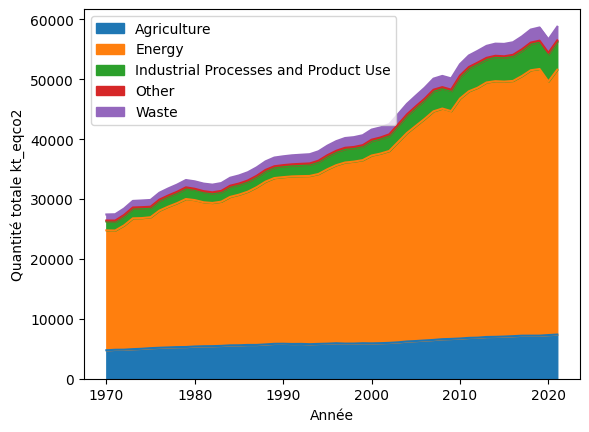

In [65]:
# Graphique empilé
# Grouper par année et substance et calculer la somme de value_eqco2
df_grouped = df_processed_edgar.groupby(['year', 'sector'])['value_mteqco2'].sum().reset_index()

# Pivoter les données pour avoir les substances comme colonnes
df_pivot = df_grouped.pivot(index='year', columns='sector', values='value_mteqco2')

# Tracer le graphique en courbes empilées
df_pivot.plot(kind='area', stacked=True)

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Année')
plt.ylabel('Quantité totale mt_eqco2')


# Afficher le graphique
plt.legend()
plt.show()